<a href="https://colab.research.google.com/github/evgeny-kolonsky/IMU/blob/main/airtrack/IMU_harmonic_oscillations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMU chip on airtrack

One-dimensional harmonic oscillations

Evgeny Kolonsky 2026

In [1]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.4 MB/s eta 0:00:00


The solution is expected to be in form
$$
x(t) = A_1 \cos (\omega_1 t + \phi_1) + A_2 \cos(\omega_2 t + \phi_2)
\tag{1}
$$
where index 1 refers to driver and index 2 refers to oscillator, or vice versa.

Hence, acceleration in axis $x$ measured in units of $g$ is expected to be
$$
\ddot x(t) = - a_1  \cos (\omega_1 t + \phi_1) - a_2 \cos(\omega_2 t + \phi_2)
\tag{2}
$$
where
$$
a_{1,2} = \frac{A_{1,2} \omega_{1,2}^2}{g}.
\tag{3}
$$

We take position measurements to fit Equation (1) from Kruze sensor and accelerometer measuremets to fit Equation (2) from IMU sensor.

Note.We took measurements from Kruze sensor and IMU unit at the same driver frequency but not at the same period of time. The amplitude (and therefore acceleration) of the driver remain unchanged, while amplitude (and therefore acceleration) decrease gradually due to the energy decay.

In [2]:
import numpy as np
from lmfit import Parameters, minimize
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize


## Direct measurements with Kruze sensor

omega1 = 7.09 rad/s2,  acc1 = 0.117 units of g
omega2 = 6.60 rad/s2,  acc2 = 0.134 units of g
Reduced Chi-square = 3.37


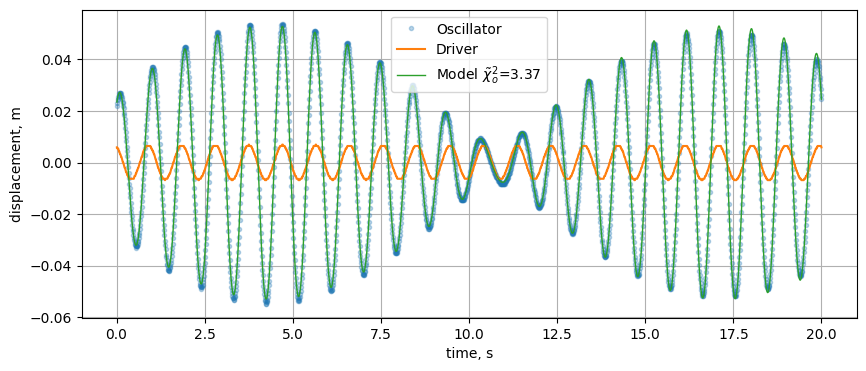

In [30]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airtrack/cartB/kruzeB.txt'

t, countA, countB = np.genfromtxt(url, skip_header=1, usecols=[1, 2, 3], delimiter='\t').T

N = 236
l = 125e-3
g = 9.8
a = countA * l / N
b = countB * l / N

a -= np.mean(a)
b -= np.mean(b)

# displacement is measured in counts with uncertainty equal to one count
uncertainty = l / N


def model(params, t):
    amp1 = params['amp1']
    phase1 = params['phase1']
    omega1 = params['omega1']
    amp2 = params['amp2']
    phase2 = params['phase2']
    omega2 = params['omega2']
    return amp1  * np.sin(t*omega1 + phase1) + amp2  * np.sin(t*omega2 + phase2)

def residual(params, x, y, uncertainty):
    return (model(params, x) - y) / uncertainty

params = Parameters()
params.add('amp1', value=1, min=0, max=6e-2)
params.add('phase1', value=0.0, min=-np.pi, max=np.pi)
params.add('omega1', value=1, min=1, max=10)
params.add('amp2', value=2,  min=0, max=6e-2)
params.add('phase2', value=0.0, min=-np.pi, max=np.pi)
params.add('omega2', value=1, min=1, max=10)

fit = minimize(residual, params, args=(t, b, uncertainty), method='dual_annealing')
b_expected = model(fit.params, t)

omega1 = fit.params['omega1'].value
amp1 = fit.params['amp1'].value
phase1 = fit.params['phase1'].value
omega2 = fit.params['omega2'].value
amp2 = fit.params['amp2'].value
phase2 = fit.params['phase2'].value
acc1 = amp1 * omega1**2 / g
acc2 = amp2 * omega2**2 / g
chi2_reduced = fit.redchi
print(f'omega1 = {omega1:.2f} rad/s2,  acc1 = {acc1:.3f} units of g')
print(f'omega2 = {omega2:.2f} rad/s2,  acc2 = {acc2:.3f} units of g')
print(f'Reduced Chi-square = {chi2_reduced:.2f}')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(t, b, '.', alpha=0.3, label='Oscillator')
plt.plot(t, a, '-', label='Driver')

plt.plot(t, b_expected, lw=1, label=fr'Model $\tilde\chi^2_o$={chi2_reduced:.2f}')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('displacement, m')
#plt.xticks([0, 4, 8, 12, 16, 20])
plt.grid()

The carts oscillate in-phase. Therefore driver ferquency is lower that natural frequency: $\omega_1 = 6.60$ rad/s is driver frequency, $\omega_2 = 7.09$ rad/s - oscillator's natural frequency.

## IMU accelerometer data

Let's look at accelerometer measurements

omega1 = 7.09 rad/s2,  acc1 = 0.112 units of g
omega2 = 6.61 rad/s2,  acc2 = 0.128 units of g
Reduced Chi-square = 1.45


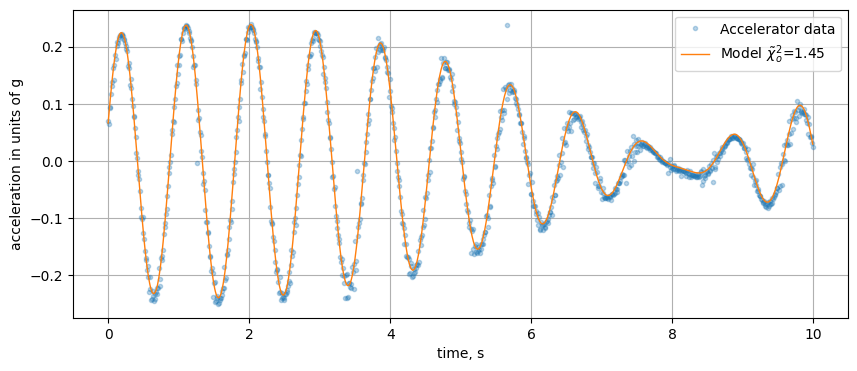

In [29]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airtrack/cartB/beats.csv'

t, ax_g, ay_g, az_g = np.genfromtxt(url, skip_header=1, usecols=[0, 1, 2, 3], delimiter=',').T


ax_g -= np.mean(ax_g)

# displacement is measured in counts with uncertainty equal to one count
uncertainty = 0.01 # in g units


def model(params, t):
    amp1 = params['amp1']
    phase1 = params['phase1']
    omega1 = params['omega1']
    amp2 = params['amp2']
    phase2 = params['phase2']
    omega2 = params['omega2']
    return amp1  * np.sin(t*omega1 + phase1) + amp2  * np.sin(t*omega2 + phase2)

def residual(params, x, y, uncertainty):
    return (model(params, x) - y) / uncertainty

params = Parameters()
params.add('amp1', value=1, min=0, max=1)
params.add('phase1', value=0.0, min=-np.pi, max=np.pi)
params.add('omega1', value=1, min=1, max=10)
params.add('amp2', value=2,  min=0, max=1)
params.add('phase2', value=0.0, min=-np.pi, max=np.pi)
params.add('omega2', value=1, min=1, max=10)

fit = minimize(residual, params, args=(t, ax_g, uncertainty), method='dual_annealing')
ax_expected = model(fit.params, t)

omega1 = fit.params['omega1'].value
amp1 = fit.params['amp1'].value
phase1 = fit.params['phase1'].value
omega2 = fit.params['omega2'].value
amp2 = fit.params['amp2'].value
phase2 = fit.params['phase2'].value
chi2_reduced = fit.redchi
print(f'omega1 = {omega1:.2f} rad/s2,  acc1 = {amp1:.3f} units of g')
print(f'omega2 = {omega2:.2f} rad/s2,  acc2 = {amp2:.3f} units of g')
print(f'Reduced Chi-square = {chi2_reduced:.2f}')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(t, ax_g, '.', alpha=0.3, label='Accelerator data')

plt.plot(t, ax_expected, lw=1, label=fr'Model $\tilde\chi^2_o$={chi2_reduced:.2f}')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('acceleration in units of g')
#plt.xticks([0, 4, 8, 12, 16, 20])
plt.grid()

And other measurement

omega1 = 7.10 rad/s2,  acc1 = 0.016 units of g
omega2 = 6.61 rad/s2,  acc2 = 0.127 units of g
Reduced Chi-square = 1.68


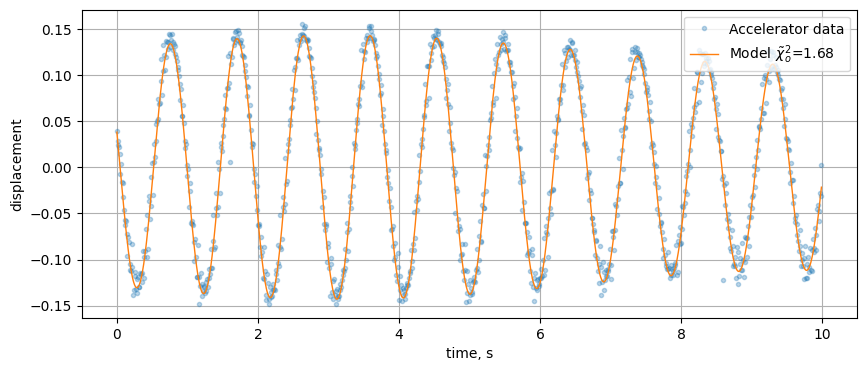

In [28]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airtrack/cartB/beats2.csv'

t, ax_g, ay_g, az_g = np.genfromtxt(url, skip_header=1, usecols=[0, 1, 2, 3], delimiter=',').T


ax_g -= np.mean(ax_g)

# displacement is measured in counts with uncertainty equal to one count
uncertainty = 0.01 # in g units


def model(params, t):
    amp1 = params['amp1']
    phase1 = params['phase1']
    omega1 = params['omega1']
    amp2 = params['amp2']
    phase2 = params['phase2']
    omega2 = params['omega2']
    return amp1  * np.sin(t*omega1 + phase1) + amp2  * np.sin(t*omega2 + phase2)

def residual(params, x, y, uncertainty):
    return (model(params, x) - y) / uncertainty

params = Parameters()
params.add('amp1', value=1, min=0, max=1)
params.add('phase1', value=0.0, min=-np.pi, max=np.pi)
params.add('omega1', value=1, min=1, max=10)
params.add('amp2', value=2,  min=0, max=1)
params.add('phase2', value=0.0, min=-np.pi, max=np.pi)
params.add('omega2', value=1, min=1, max=10)

fit = minimize(residual, params, args=(t, ax_g, uncertainty), method='dual_annealing')
ax_expected = model(fit.params, t)

omega1 = fit.params['omega1'].value
amp1 = fit.params['amp1'].value
phase1 = fit.params['phase1'].value
omega2 = fit.params['omega2'].value
amp2 = fit.params['amp2'].value
phase2 = fit.params['phase2'].value
chi2_reduced = fit.redchi
print(f'omega1 = {omega1:.2f} rad/s2,  acc1 = {amp1:.3f} units of g')
print(f'omega2 = {omega2:.2f} rad/s2,  acc2 = {amp2:.3f} units of g')
print(f'Reduced Chi-square = {chi2_reduced:.2f}')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(t, ax_g, '.', alpha=0.3, label='Accelerator data')

plt.plot(t, ax_expected, lw=1, label=fr'Model $\tilde\chi^2_o$={chi2_reduced:.2f}')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('acceleration in units of g')
plt.grid()

And another one measurement

omega1 = 6.62 rad/s2,  acc1 = 0.132 units of g
omega2 = 7.09 rad/s2,  acc2 = 0.126 units of g
Reduced Chi-square = 1.02


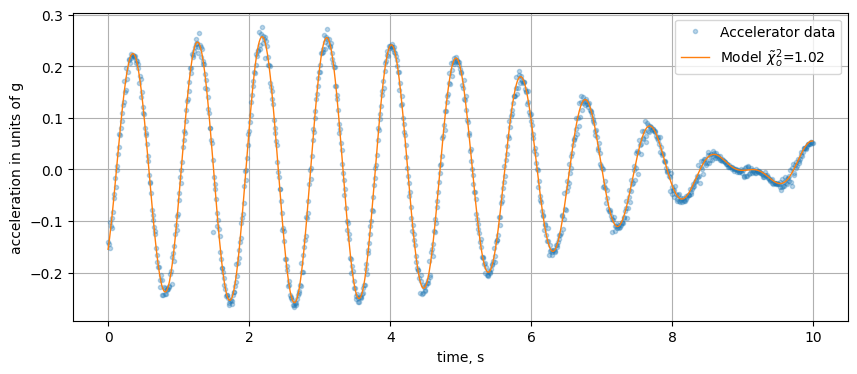

In [33]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airtrack/cartB/beats3.csv'

t, ax_g, ay_g, az_g = np.genfromtxt(url, skip_header=1, usecols=[0, 1, 2, 3], delimiter=',').T


ax_g -= np.mean(ax_g)

# displacement is measured in counts with uncertainty equal to one count
uncertainty = 0.01 # in g units


def model(params, t):
    amp1 = params['amp1']
    phase1 = params['phase1']
    omega1 = params['omega1']
    amp2 = params['amp2']
    phase2 = params['phase2']
    omega2 = params['omega2']
    return amp1  * np.sin(t*omega1 + phase1) + amp2  * np.sin(t*omega2 + phase2)

def residual(params, x, y, uncertainty):
    return (model(params, x) - y) / uncertainty

params = Parameters()
params.add('amp1', value=1, min=0, max=1)
params.add('phase1', value=0.0, min=-np.pi, max=np.pi)
params.add('omega1', value=1, min=1, max=10)
params.add('amp2', value=2,  min=0, max=1)
params.add('phase2', value=0.0, min=-np.pi, max=np.pi)
params.add('omega2', value=1, min=1, max=10)

fit = minimize(residual, params, args=(t, ax_g, uncertainty), method='dual_annealing')
ax_expected = model(fit.params, t)

omega1 = fit.params['omega1'].value
amp1 = fit.params['amp1'].value
phase1 = fit.params['phase1'].value
omega2 = fit.params['omega2'].value
amp2 = fit.params['amp2'].value
phase2 = fit.params['phase2'].value
chi2_reduced = fit.redchi
print(f'omega1 = {omega1:.2f} rad/s2,  acc1 = {amp1:.3f} units of g')
print(f'omega2 = {omega2:.2f} rad/s2,  acc2 = {amp2:.3f} units of g')
print(f'Reduced Chi-square = {chi2_reduced:.2f}')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(t, ax_g, '.', alpha=0.3, label='Accelerator data')

plt.plot(t, ax_expected, lw=1, label=fr'Model $\tilde\chi^2_o$={chi2_reduced:.2f}')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('acceleration in units of g')
plt.grid()
